In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1)

In [2]:
DATA_PATH = "data/"
TRAIN_DATA_FILE = "exoTrainData_upsampled.npy"
TRAIN_LABELS_FILE = "exoTrainLabels_upsampled.npy"
TEST_DATA_FILE = "exoTestData.npy"
TEST_LABELS_FILE = "exoTestLabels.npy"

x_train = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_FILE))
y_train = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_FILE))
x_test = np.load("{}{}".format(DATA_PATH, TEST_DATA_FILE))
y_test = np.load("{}{}".format(DATA_PATH, TEST_LABELS_FILE))

# TODO: actually get this in some time units so can set autopower arg more legitimately
t = np.arange(x_train.shape[1])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10082, 3197)
(10082,)
(570, 3197)
(570,)


# Box Least Squares

In [ ]:
from astropy.stats import BoxLeastSquares

for i in range(5):
    plt.plot(t, x_train[i])
    plt.xlabel("t")
    plt.ylabel("Flux")
    plt.show()
    bls = BoxLeastSquares(t, x_train[i])
    periodogram = bls.autopower(20, minimum_n_transit=5)  # arg is the granularity of considered durations
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.show()

In [ ]:
from sklearn import metrics

def compute_metrics(clf, x_train, y_train, x_test, y_test):
    print("Accuracy on training data:", clf.score(x_train, y_train))
    print("Accuracy on test data:", clf.score(x_test, y_test))
    test_predicted_probs = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predicted_probs)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print("AUC:", metrics.auc(fpr, tpr))
    test_predicted = clf.predict(x_test)
    print("F1:", metrics.f1_score(y_test, test_predicted))
    print("Test prediction frequencies:")
    print(np.unique(test_predicted, return_counts=True))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, test_predicted))
    print()

In [ ]:
from astropy.stats import BoxLeastSquares

stat_names = ["depth", "depth_odd", "depth_even", "depth_half", "depth_phased"]

def get_bls_features(x):
    features = []
    for i in range(x.shape[0]):
        # adapted from http://docs.astropy.org/en/stable/stats/bls.html#peak-statistics
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(40, minimum_n_transit=5)  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        stats = bls.compute_stats(periodogram.period[max_power],
                                    periodogram.duration[max_power],
                                    periodogram.transit_time[max_power])
        # TODO: use dataframe?
        features.append([stats[s][0] / stats[s][1] for s in stat_names])
        # based on https://arxiv.org/pdf/astro-ph/0206099.pdf
#         ratios.append(stats["depth"][0] / stats["depth"][1])  # depth over uncertainty
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(features)

In [ ]:
%%time

bls_train_features = get_bls_features(x_train)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bls_train_features = scaler.fit_transform(bls_train_features)

In [ ]:
from sklearn.linear_model import LogisticRegression

bls_logit = LogisticRegression()
bls_logit.fit(bls_train_features, y_train)

In [ ]:
print(bls_logit.coef_)
# print(bls_train_ratios.min(), bls_train_ratios.max())
# print("Ratio decision boundary:", -bls_logit.intercept_ / bls_logit.coef_)

# TODO: plot data with decision boundary

In [ ]:
bls_test_features = get_bls_features(x_test)

In [ ]:
bls_test_features = scaler.transform(bls_test_features)

In [ ]:
# plt.scatter(np.arange(bls_test_ratios.shape[0]), bls_test_ratios.flatten(), c=y_test, cmap="coolwarm")
# plt.show()

In [ ]:
compute_metrics(bls_logit, bls_train_features, y_train, bls_test_features, y_test)

# LSTM

In [12]:
%%time

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

BATCH_SIZE = 32
N_EPOCHS = 30
N_TRAIN = 5000 // BATCH_SIZE * BATCH_SIZE
N_TEST = x_test.shape[0] // BATCH_SIZE * BATCH_SIZE

model = Sequential([
    LSTM(16, input_shape=(x_train.shape[1], 1), batch_input_shape=(BATCH_SIZE, x_train.shape[1], 1), stateful=True, dropout=0.2, recurrent_dropout=0.2),
    Dense(1),
])
# TODO: do balancing in a generator
model.compile(optimizer=Adam(3e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
train_indices = np.random.choice(x_train.shape[0], N_TRAIN, replace=False)
x_train_lstm = x_train[train_indices, :, np.newaxis]
y_train_lstm = y_train[train_indices]
x_test_lstm = x_test[:N_TEST, :, np.newaxis]
y_test_lstm = y_test[:N_TEST]
train_accuracies = []
test_accuracies = []
for i in range(N_EPOCHS):
    hist = model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=1, batch_size=BATCH_SIZE, shuffle=False)
    model.reset_states()
    train_accuracies.append(hist.history["acc"])
    test_accuracies.append(hist.history["val_acc"])

Train on 2976 samples, validate on 544 samples
Epoch 1/1
2976/2976 [==============================] - 102s 34ms/step - loss: 3.1901 - acc: 0.4741 - val_loss: 0.8583 - val_acc: 0.7224
Train on 2976 samples, validate on 544 samples
Epoch 1/1
2976/2976 [==============================] - 296s 99ms/step - loss: 2.0071 - acc: 0.5188 - val_loss: 0.6827 - val_acc: 0.7518
Train on 2976 samples, validate on 544 samples
Epoch 1/1
2976/2976 [==============================] - 99s 33ms/step - loss: 1.7436 - acc: 0.5349 - val_loss: 0.5149 - val_acc: 0.8235
Train on 2976 samples, validate on 544 samples
Epoch 1/1
2976/2976 [==============================] - 99s 33ms/step - loss: 1.6559 - acc: 0.5309 - val_loss: 0.4861 - val_acc: 0.8346
Train on 2976 samples, validate on 544 samples
Epoch 1/1
2976/2976 [==============================] - 105s 35ms/step - loss: 1.5023 - acc: 0.5356 - val_loss: 0.4820 - val_acc: 0.8235
Train on 2976 samples, validate on 544 samples
Epoch 1/1
2976/2976 [===================

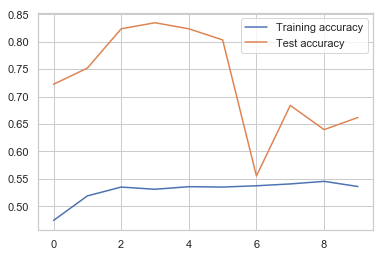

In [13]:
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

In [ ]:
# 16 neurons, no dropout, 10 epochs, 3000 training samples, 1e-3
# 0.7144
# 0.5276

# same as above, but with 0.4 dropout and recurrent_dropout, 1e-3
# 0.5242
# 0.5478

# 16 neurons, 0.4 dropout, 10 epochs, 3000 training samples, 2e-4
# 0.4657
# 0.8327

# 32 neurons, 0.4 dropout, 10 epochs, 3000 training samples, 3e-4
# 0.5360
# 0.6618

# 0.2 dropout, 30 epochs, 5000 training samples, 3e-4
# 